# Multilevel intercepts

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta * log(LA)_i \\
\alpha_{j}\sim Normal(\alpha, \sigma),\space for\space j = 1...J\space neighbourhoods\\
\alpha\sim Normal(1, 0.5)\\
\sigma\sim Half-Normal(0, 1)\\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

In [51]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

# Train/Test data
train = pd.read_csv('../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

In [52]:
# Import multilevel model
multilevel_model = pystan.StanModel(file = '../src/models/multilevel_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00eeba72f2f20d138ee43a0ad4eb61a6 NOW.


In [23]:
data_check = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           beta_sd = 0.1, 
           run_estimation = 0)

fit_model_check = multilevel_model.sampling(data=data_check)
df_model_check = fit_model_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Prior predcitive checks

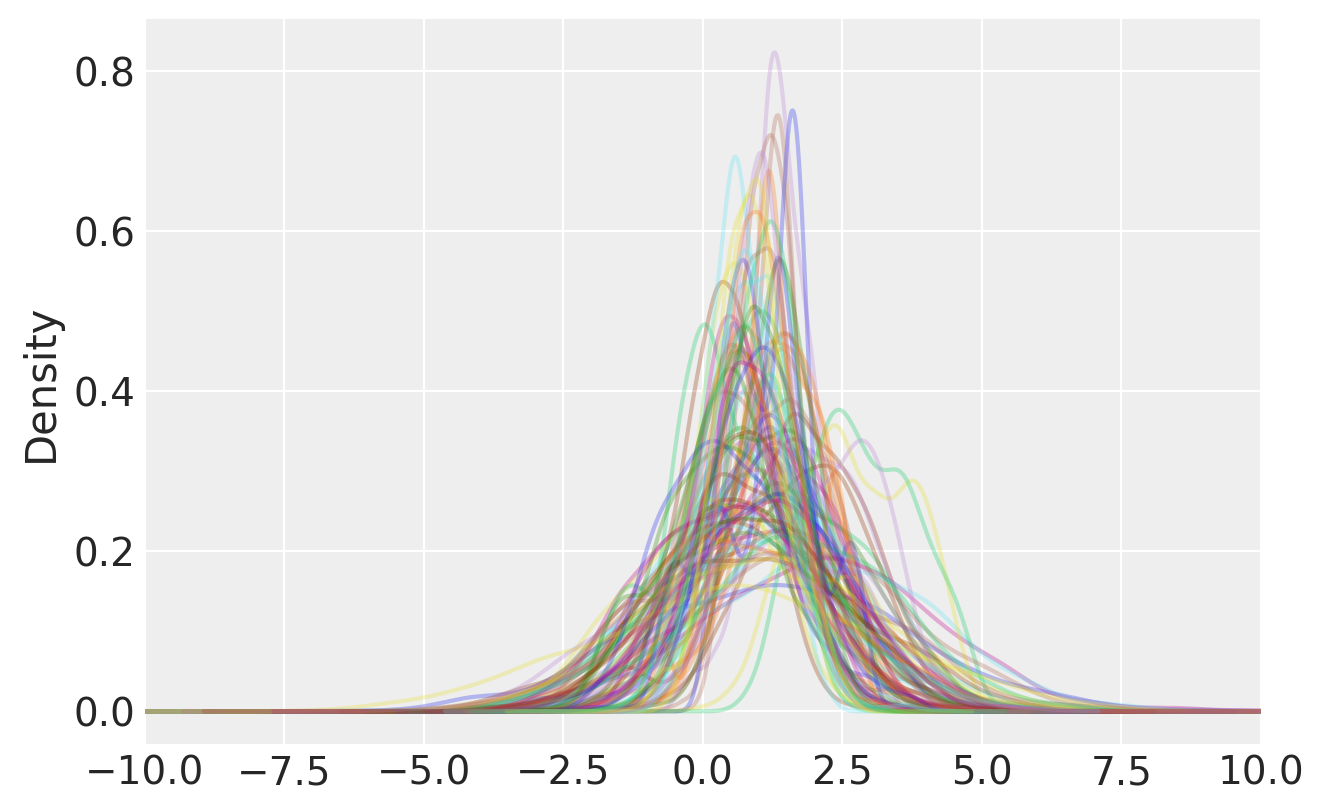

In [24]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

fit_model_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-10, 10));

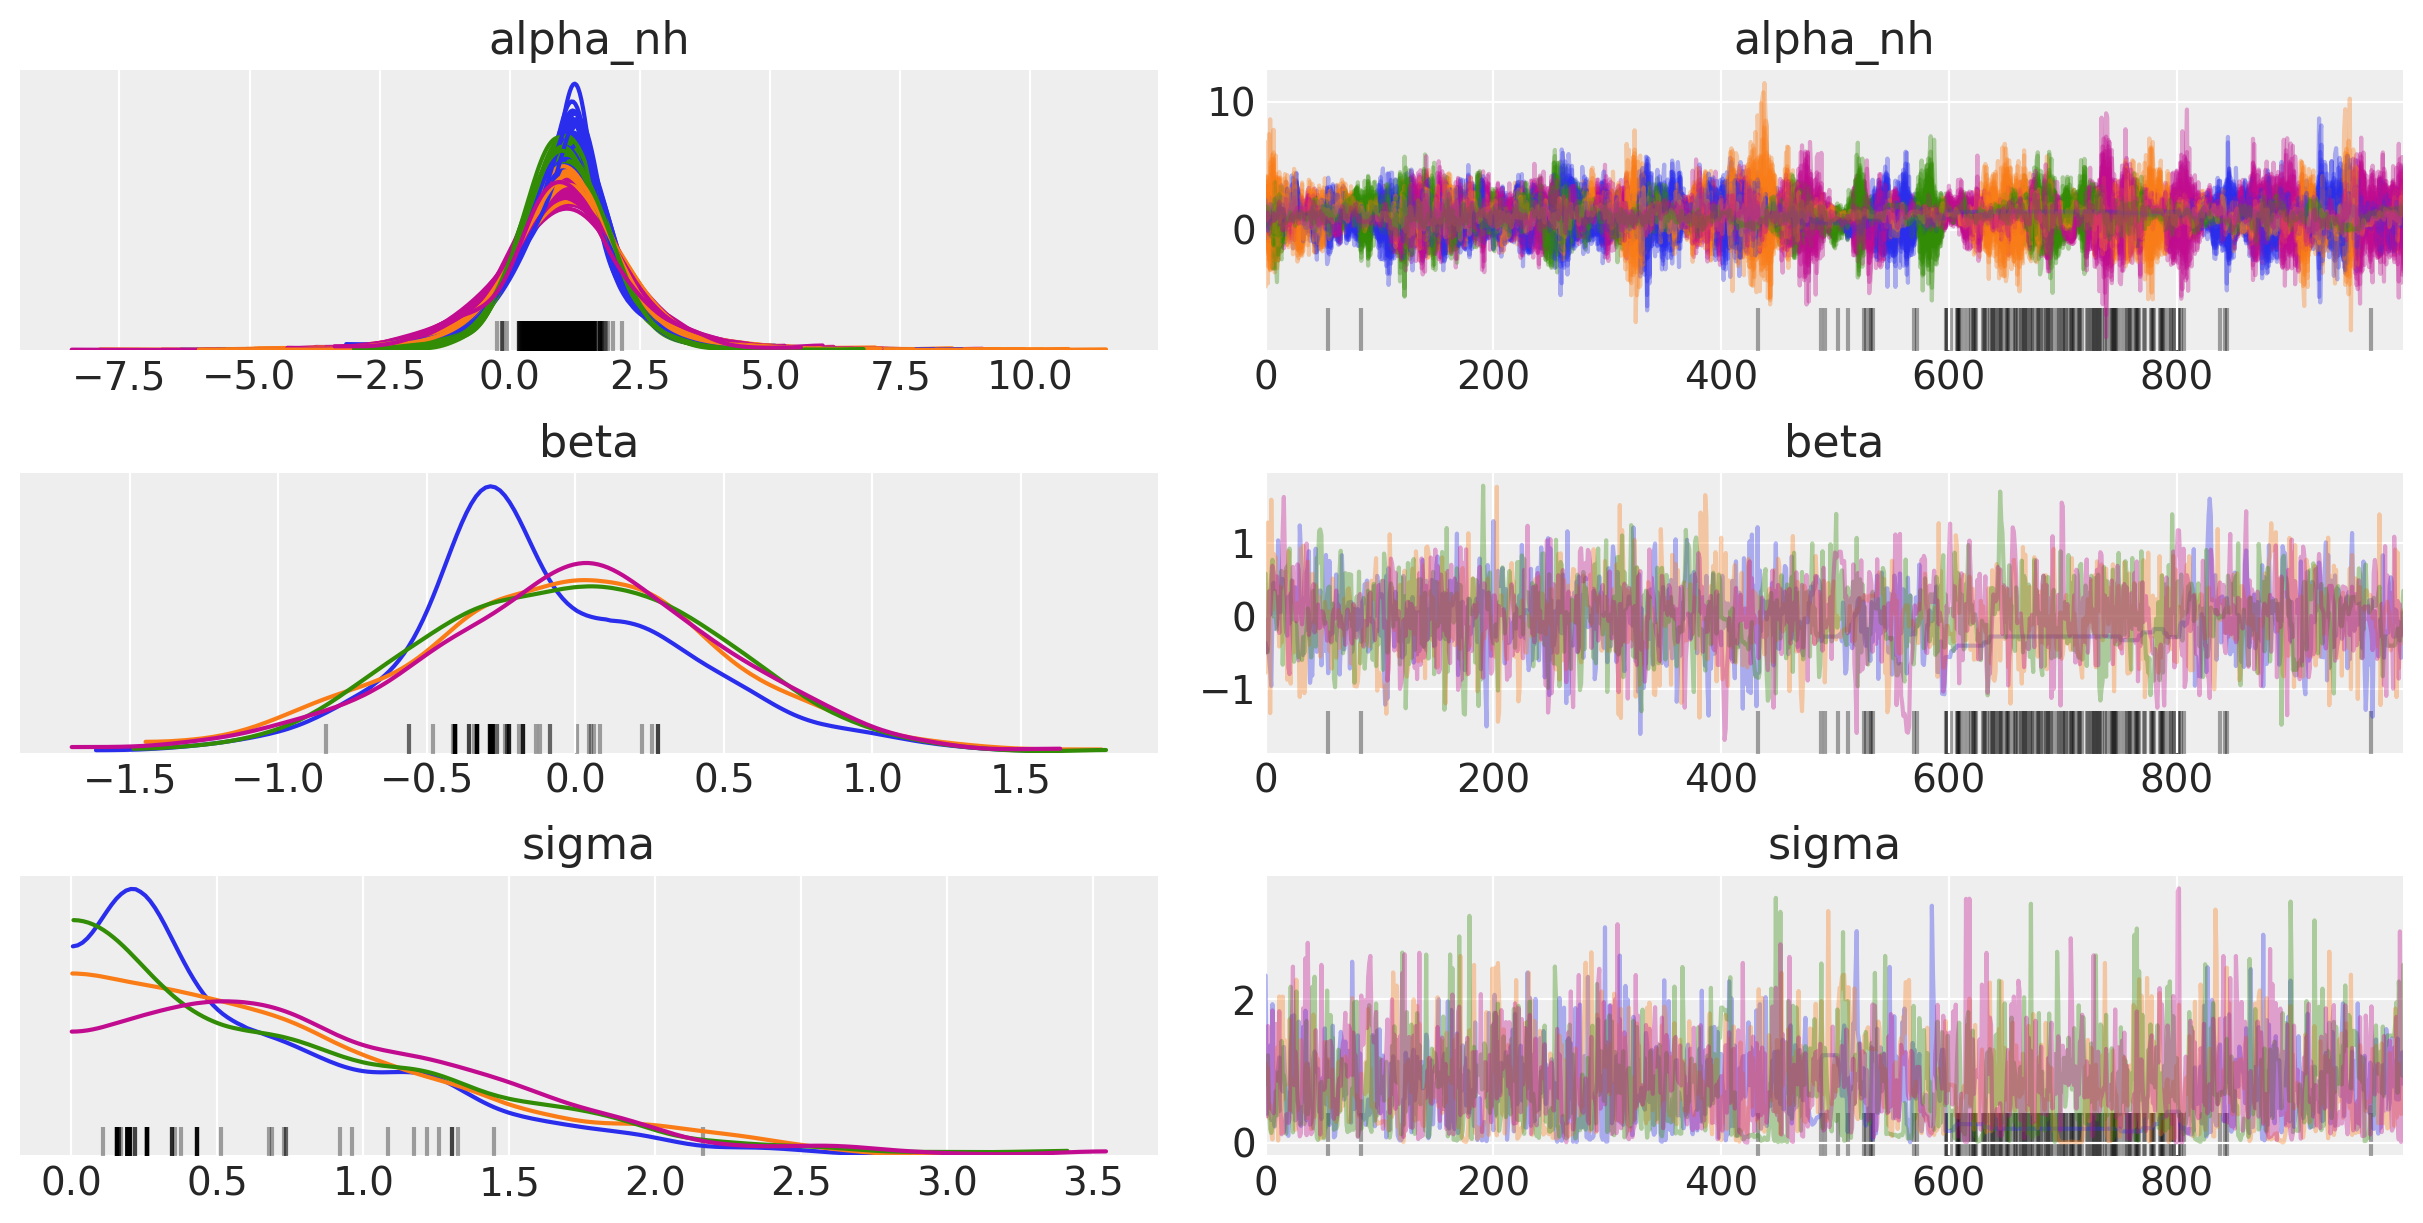

In [25]:
az.plot_trace(fit_model_check, var_names=["alpha_nh", "beta", "sigma"], compact = True);

In [ ]:
## Fit model on fake data and recapture known parameters (appendix?)

In [ ]:
## Fit model on real data

In [53]:
data = dict(N = len(train),
           log_sales_price = train['log_sales_price_std'],
           log_lot_area = train['log_lot_area_z'],
           neighbourhood = train['neighbourhood'],
           N_neighbourhood = len(train['Neighborhood'].unique()),
           N_test = len(test),
           log_lot_area_test = test['log_lot_area_z'],
           neighbourhood_test = test['neighbourhood'],
           beta_sd = 0.1, 
           run_estimation = 1)

fit_model = multilevel_model.sampling(data=data)
df_model = fit_model.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


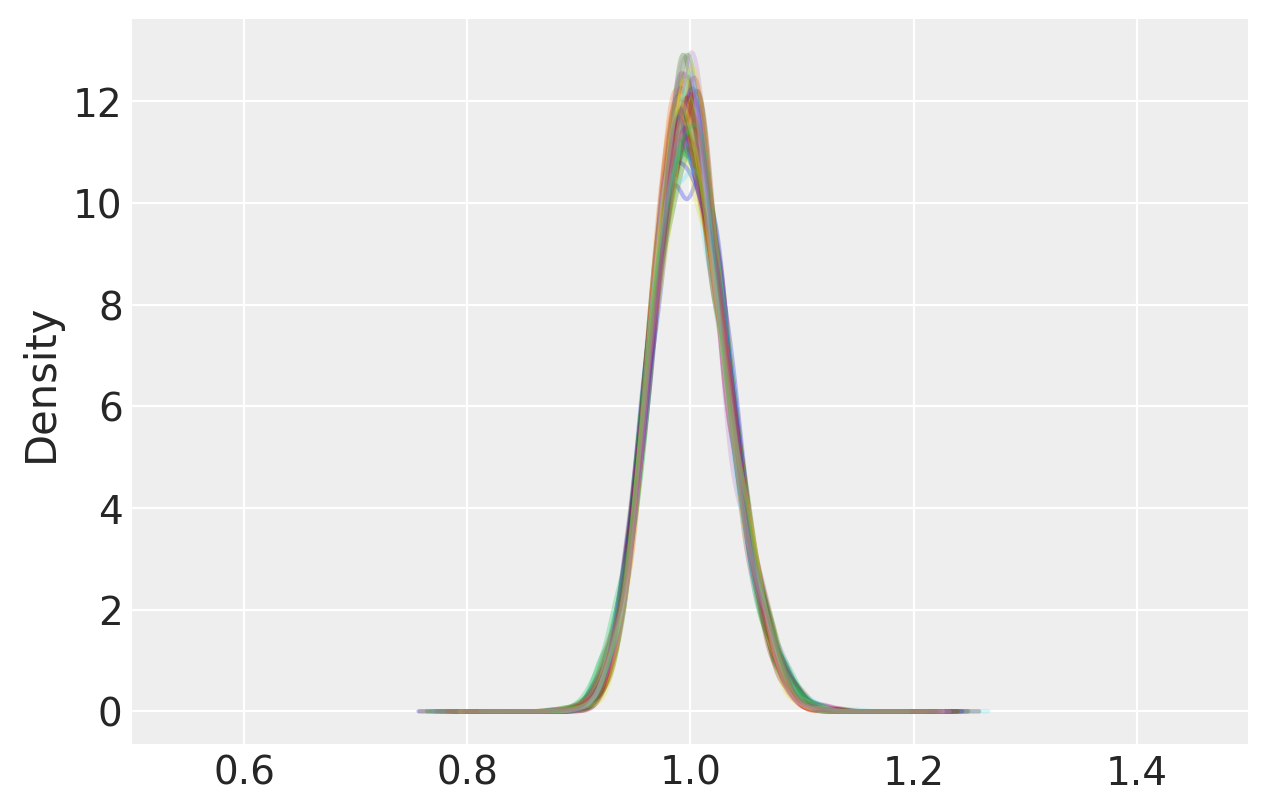

In [54]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

df_model.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (.5, 1.5));

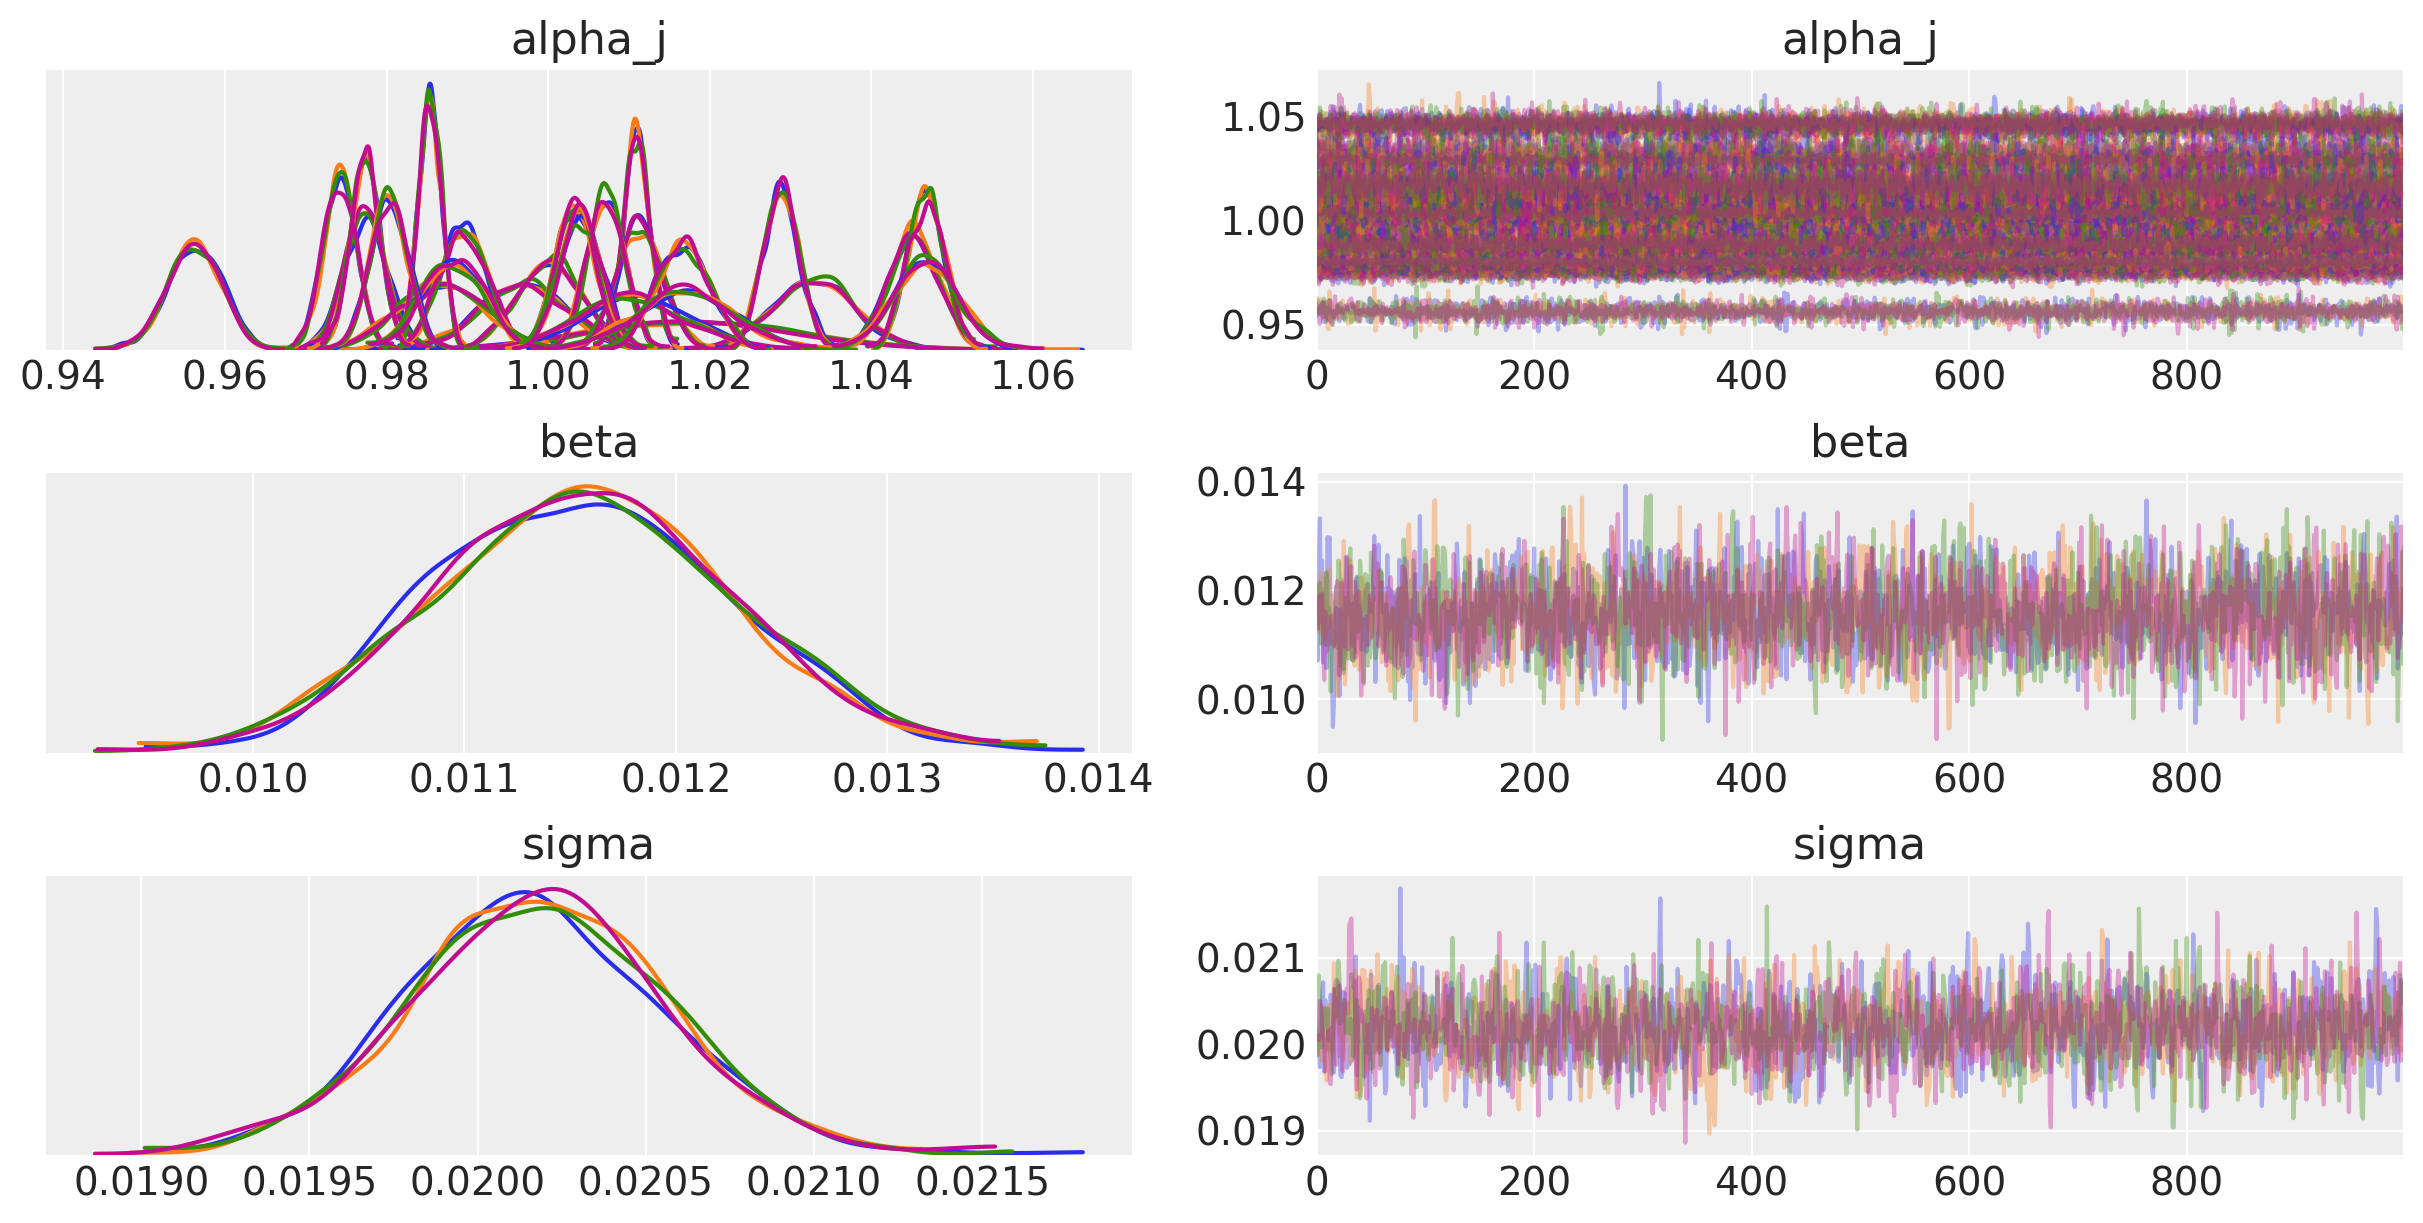

In [57]:
az.plot_trace(fit_model, var_names=["alpha_j", "beta", "sigma"], compact = True);

In [58]:
predictions = pd.DataFrame(np.exp(df_model.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

multilevel_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

multilevel_csv.to_csv('../data/submissions/multilevel_model.csv', index = False)